# Calculate Recharge Metric based on tTEM Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy.interpolate import NearestNDInterpolator, RBFInterpolator
from scipy.spatial import cKDTree as KDTree
from verde import distance_mask
import scipy
from scipy.spatial import ConvexHull
from scipy.spatial import distance_matrix
import matplotlib
import warnings
from scipy.interpolate import griddata
warnings.filterwarnings("ignore")
from scipy.interpolate import LinearNDInterpolator
from emrecharge.viz import (
    Stitched1DModel, generate_average_map
)

from shapely.geometry import Polygon
from scipy.stats.mstats import gmean



# Import Shapefile for Study Area

In [3]:
# basins shape file if want to look at county
gdf_basins = gpd.read_file('Example_Data/California Groundwater Basins/CA_Bullitin118Basins.shp').to_crs(3310)

#can change to whatever shapefile of area of interest
path = "Example_Data/Ball Ranch Survey/Ball_Ranch_Survey_Points.shp"
gdf_survey_points = gpd.read_file(path)

xmin,ymin, xmax, ymax = gdf_survey_points.total_bounds
x_points = [xmin, xmin, xmax, xmax]
y_points = [ymin, ymax, ymax, ymin]

geom = Polygon(zip(x_points, y_points))
gdf_shape = gpd.GeoDataFrame(index=[0], crs=32611, geometry=[geom])

# Get tTEM Data

## Load Resistivity Data

In [4]:
import io
def read_work_bench_xyz_mod(fname):
    with open(fname, 'r') as fid:
        lines = fid.readlines()
    n_header_max = 100
    for ii, line in enumerate(lines):
        if '/' in line:
            pass
        else:
            break

    header = lines[ii-1].split()[1:]
    n_columns = len(header)
    n_sounding = len(lines[ii:])
    data = np.zeros((n_sounding, n_columns))
    for jj, line in enumerate(lines[ii:]):
        data[jj,:] = np.array(line.split(), dtype=float)
    df = pd.DataFrame(data=data, columns=header)
    tmp_thk = np.array(header)[['THK' in header for header in header]]
    thk_names = tmp_thk[:int(len(tmp_thk)/2)]
    tmp_rho = np.array(header)[['RHO' in header for header in header]]
    rho_names = tmp_rho[:int(len(tmp_thk)/2)+1]
    topo = df[['UTMX', 'UTMY', 'ELEVATION']].values[:, :]
    hz = np.unique(df[thk_names].values)
    hz = np.r_[hz, hz[-1]]
    resistivity= df[rho_names].values[:,:]
    line = df['LINE_NO'].values
    return df, topo, hz, resistivity, line

In [6]:
file_name = "Example_Data/Ball_Ranch_Inv_File/SCI_I01_MOD_inv.xyz"
df, topography, hz, resistivity, line = read_work_bench_xyz_mod(file_name)

In [7]:
hz_ft = hz * 3.28084
thickness = np.copy(hz_ft)

In [8]:
hz_ft = np.cumsum(hz_ft)

## Get Resistivity Data Above Water Table

In [9]:
max_depth = 17
ind_above = np.where(hz_ft<max_depth)[0]
res_above = resistivity[:,ind_above]
res_above_avg = np.dot(res_above, thickness[ind_above])/hz_ft[ind_above[-1]]
min_res = np.min(res_above, axis = 1)

#get depth of limiting layer
depth_ll = []
for i in range(len(min_res)):
    idx_min = np.where(res_above[i]==min_res[i])[0]
    depth_ll.append(hz_ft[idx_min])
ll_depth = np.array(depth_ll)

ll_res = 15
ll_idx = np.where(min_res < ll_res)

In [10]:
# importing the style package
from matplotlib import style
plt.style.use('ggplot')

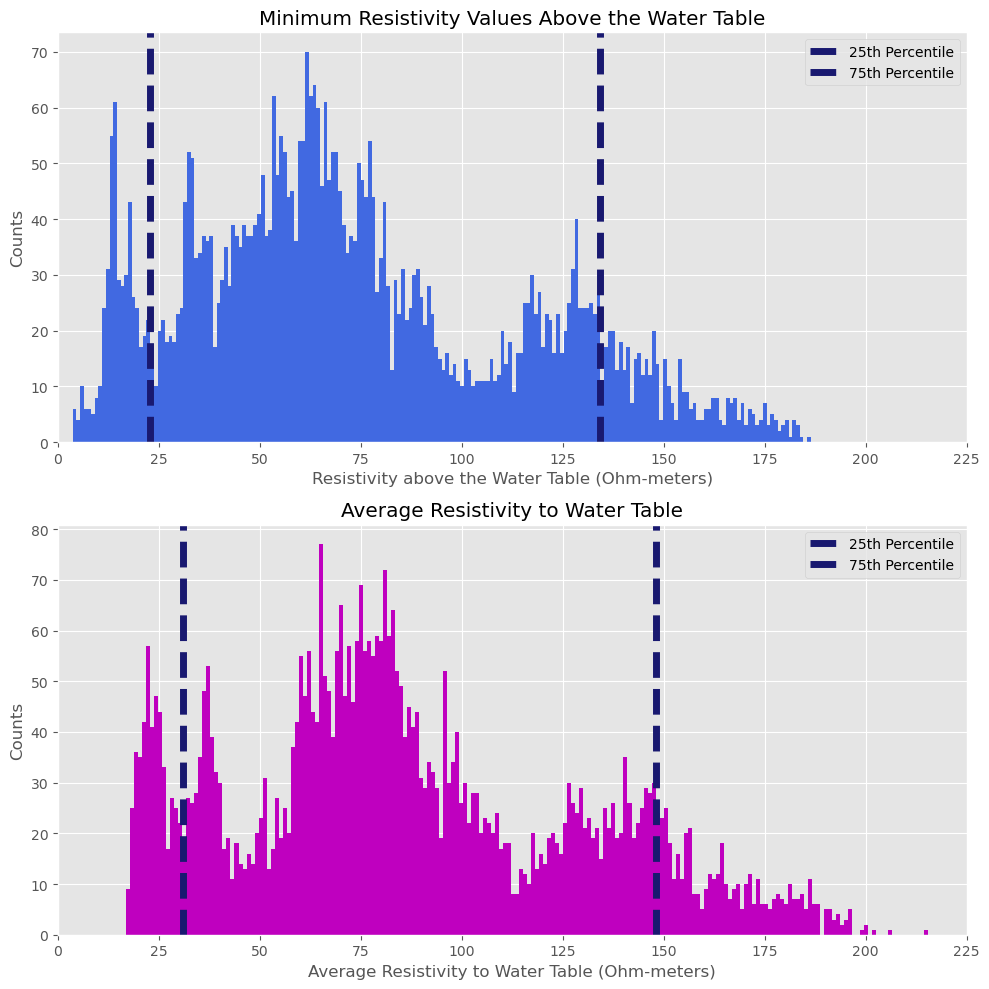

In [11]:
plt.figure(figsize = (10, 10))
plt.subplot(211)
plt.hist(min_res, bins = 200, color = 'royalblue')
plt.axvline(
    np.quantile(min_res, .10), color = 'midnightblue', linewidth = 5, label = '25th Percentile', 
    linestyle = 'dashed')
plt.axvline(
    np.quantile(min_res, .90),color = 'midnightblue', linewidth = 5, label = '75th Percentile'
    ,linestyle = 'dashed'
)
plt.title('Minimum Resistivity Values Above the Water Table')
plt.xlabel("Resistivity above the Water Table (Ohm-meters)")
plt.ylabel('Counts')
plt.legend()
plt.xlim(0, 225)

plt.subplot(212)
plt.hist(res_above_avg, bins = 200, color = 'm')
plt.axvline(
    np.quantile(res_above_avg, .10), color = 'midnightblue', linewidth = 5, label = '25th Percentile', 
    linestyle = 'dashed')
plt.axvline(
    np.quantile(res_above_avg, .90),color = 'midnightblue', linewidth = 5, label = '75th Percentile', 
    linestyle = 'dashed')
plt.title('Average Resistivity to Water Table')
plt.xlabel("Average Resistivity to Water Table (Ohm-meters)")
plt.ylabel('Counts')
plt.legend()
plt.xlim(0, 225)

plt.tight_layout()

# Interpolate Resistivity Results

In [12]:
from scipy.interpolate import NearestNDInterpolator
from scipy.spatial import cKDTree as KDTree
from verde import distance_mask
def inverse_distance_interpolation(
    xy, values, 
    dx=10, dy=10, x_pad=0, y_pad=0,
    power=0, epsilon=None, k_nearest_points=2, 
    max_distance=30.,
):
    """
        Evaluating 2D inverse distance weighting interpolation
        for given (x, y) points and values.
        
        Inverse distance weight, w, can be written as:
            w = 1/(distance+epsilon)**power
        
        Parameters
        ----------
        xy : array_like
            Input array including (x, y) locations; (n_locations, 2)
        values: array_like
            Input array including values defined at (x, y) locations; (n_locations, )
        dx : int 
            Size of the uniform grid in x-direction
        dy : int 
            Size of the uniform grid in y-direction
        x_pad : float 
            Length of padding in x-direction
        y_pad : float 
            Length of padding in y-direction
        power: float
            Exponent used when evaluating inverse distance weight. 
        epsilon: float
            A floor value used when evaluating inverse distance weight. 
        k_nearest_points: int 
            k-nearest-point used when evaluating inverse distance weight.  
        max_distance: float
            A separation distance used to maks grid points away from the (x, y) locations.
        
        Returns        
        -------
        

    """
    xmin, xmax = xy[:,0].min()-x_pad, xy[:,0].max()+x_pad
    ymin, ymax = xy[:,1].min()-y_pad, xy[:,1].max()+y_pad

    nx = int((xmax-xmin) / dx)
    ny = int((ymax-ymin) / dy)
    hx = np.ones(nx) * dx
    hy = np.ones(ny) * dy
    x = np.arange(nx)*dx + xmin
    y = np.arange(ny)*dy + ymin
    X, Y = np.meshgrid(x, y)

    tree = KDTree(xy)

    d, inds_idw = tree.query(np.c_[X.flatten(), Y.flatten()], k=int(k_nearest_points))
    if epsilon is None:
        epsilon = np.min([dx, dy])
    w = 1.0 / ((d+epsilon) ** power)
    values_idw = (np.sum(w * values[inds_idw], axis=1) / np.sum(w, axis=1))
    mask_inds = ~distance_mask(
        (xy[:,0], xy[:,1]), maxdist=max_distance, coordinates=(X.flatten(), Y.flatten())
    )
    values_idw[mask_inds] = np.nan
    values_idw = values_idw.reshape(X.shape)
    return x, y, values_idw


xy_res = np.array([topography[:,0], topography[:,1]]).T
x, y, res_above = inverse_distance_interpolation(xy_res, res_above_avg)
x, y, ll_res = inverse_distance_interpolation(xy_res, min_res)

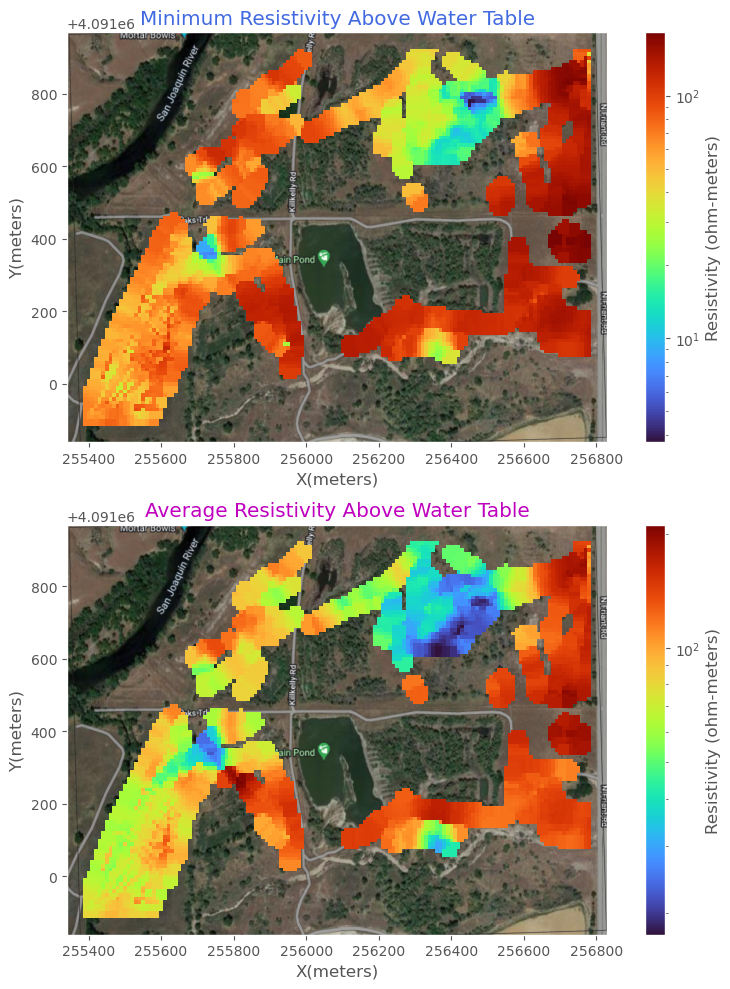

In [23]:
background_tTEM = plt.imread("Example_Data/ttem_br.png")
dx_tTEM = 50
extent = [x.min()-dx_tTEM, x.max()+dx_tTEM, y.min()-dx_tTEM, y.max()+dx_tTEM]
plt.figure(figsize = (8,10))
plt.subplot(211)
plt.imshow(background_tTEM, extent = extent)
plt.title("Minimum Resistivity Above Water Table", color = 'royalblue')
plt.pcolormesh(x, y, ll_res, cmap = 'turbo', norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar()
cbar.set_label("Resistivity (ohm-meters)")
plt.xlabel("X(meters)")
plt.ylabel("Y(meters)")
plt.xlim(x.min()-dx_tTEM, x.max()+dx_tTEM)
plt.ylim(y.min()-dx_tTEM, y.max()+dx_tTEM)

plt.subplot(212)
plt.imshow(background_tTEM, extent = extent)
plt.title("Average Resistivity Above Water Table", color = 'm')
plt.pcolormesh(x, y, res_above, cmap = 'turbo', norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar()
cbar.set_label("Resistivity (ohm-meters)")
plt.xlabel("X(meters)")
plt.ylabel("Y(meters)")
plt.xlim(x.min()-dx_tTEM, x.max()+dx_tTEM)
plt.ylim(y.min()-dx_tTEM, y.max()+dx_tTEM)

plt.tight_layout()

In [24]:
#get limitiing layer index
ll_min_res = 25

x_grid, y_grid = np.meshgrid(x,y)
x_flat, y_flat = x_grid.flatten(), y_grid.flatten()
ll_res_flat = ll_res.flatten()
ll_idx = np.where(ll_res_flat < ll_min_res)

In [26]:
dic_survey = {'X':x_flat, 'Y': y_flat, "Avg_Res": res_above.flatten(),
             'Min_Res': ll_res_flat}
df_survey = pd.DataFrame(dic_survey)
gdf_survey = gpd.GeoDataFrame(df_survey, 
                              geometry = gpd.points_from_xy(df_survey.X, df_survey.Y),
                             crs = 32611)

In [29]:
def get_score(min_val, max_val, values):
    m = 100/(max_val-min_val)
    b = -1*m*min_val
    temp_vals = m*values + b
    temp_vals[temp_vals<0]=0
    temp_vals[temp_vals>100]=100
    return temp_vals

score_ll = get_score(10, 50, gdf_survey.Min_Res.values)
score_res = get_score(30, 80, gdf_survey.Avg_Res.values)

avg_score = (score_ll+score_res)/2

min_score = []
min_index = []
for i in range(len(score_ll)):
    temp_scores = np.array([score_ll[i], score_res[i]])
    if np.isnan(temp_scores[0]):
        min_index.append(np.nan)
    else:
        min_index.append(np.where(temp_scores==min(temp_scores))[0][0])
    min_score.append(min(temp_scores))
min_score = np.array(min_score)
min_index = np.array(min_index)

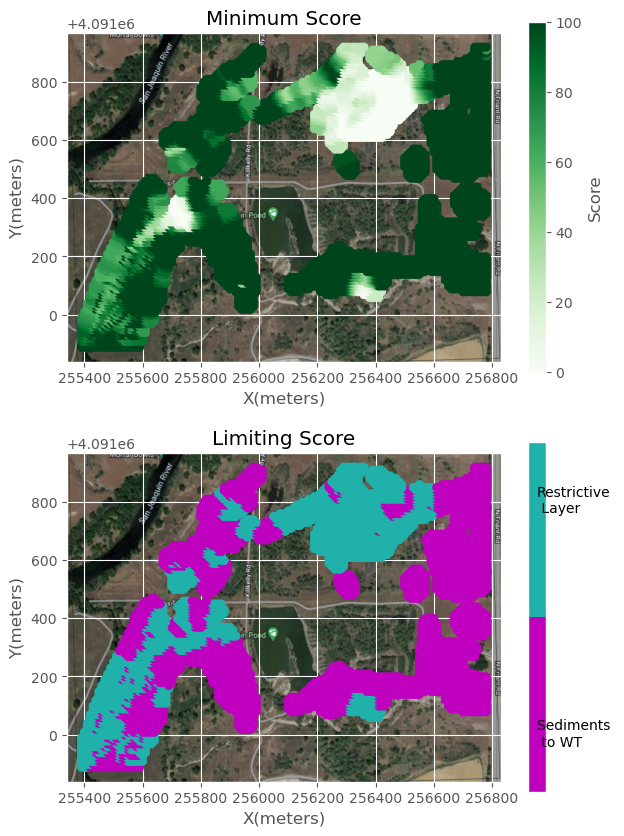

In [33]:
plt.figure(figsize = (7, 10))
plt.subplot(211)
plt.imshow(background_tTEM, extent = extent)
plt.title("Minimum Score")
plt.scatter(gdf_survey.X, gdf_survey.Y, c = min_score, cmap = 'Greens')
cbar = plt.colorbar()
cbar.set_label("Score")
plt.xlabel("X(meters)")
plt.ylabel("Y(meters)")

import matplotlib

cmap = matplotlib.colors.ListedColormap([ 'm', 'lightseagreen'])

plt.subplot(212)
plt.imshow(background_tTEM, extent = extent)
plt.title("Limiting Score")
plt.scatter(gdf_survey.X, gdf_survey.Y, c = min_index, cmap = cmap)
cbar = plt.colorbar()
plt.xlabel("X(meters)")
plt.ylabel("Y(meters)")
cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(['Sediments \n to WT','Restrictive\n Layer']):
    cbar.ax.text(.5, (2 * j+0.5 ) / 3.0, lab, ha='left', va='center')
cbar.ax.get_yaxis().labelpad = 15

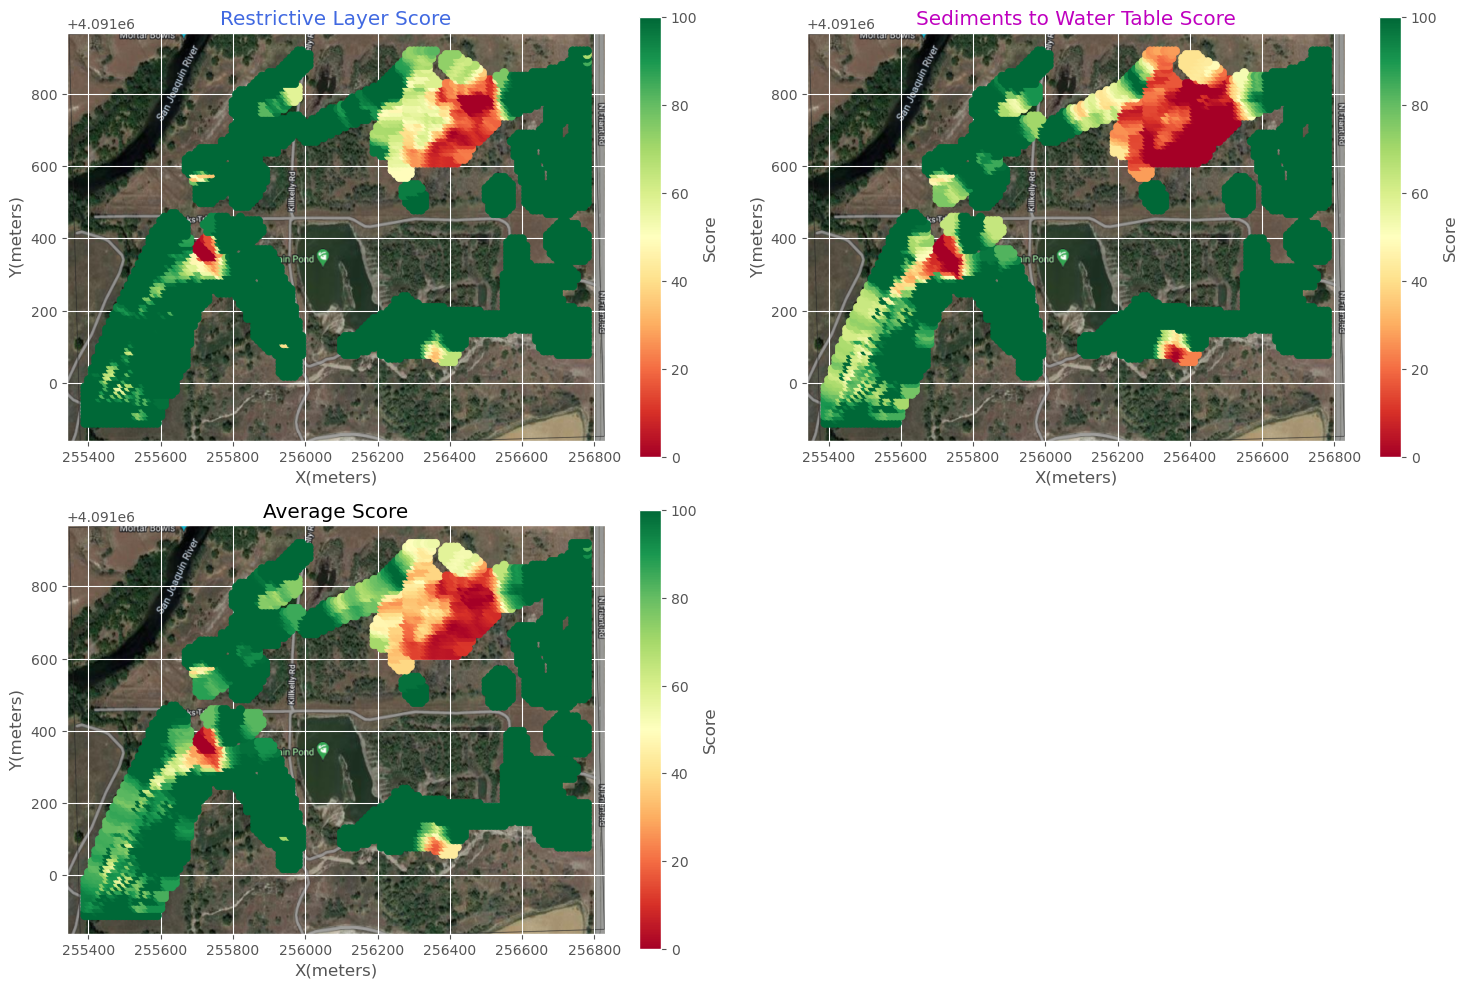

In [35]:
nx, ny = len(x), len(y)
plt.figure(figsize = (15, 10))

plt.subplot(221)
plt.imshow(background_tTEM, extent = extent)
plt.title("Restrictive Layer Score", color = 'royalblue')
plt.scatter(gdf_survey.X.values, gdf_survey.Y.values, c = score_ll, cmap = 'RdYlGn')
cbar = plt.colorbar()
plt.xlabel("X(meters)")
plt.ylabel("Y(meters)")
cbar.set_label("Score")

plt.subplot(222)
plt.imshow(background_tTEM, extent = extent)
plt.title("Sediments to Water Table Score", color ='m')
plt.scatter(gdf_survey.X, gdf_survey.Y, c = score_res, cmap = 'RdYlGn')
cbar = plt.colorbar()
plt.xlabel("X(meters)")
plt.ylabel("Y(meters)")
cbar.set_label("Score")

plt.subplot(223)
plt.imshow(background_tTEM, extent = extent)
plt.title("Average Score")
plt.scatter(gdf_survey.X, gdf_survey.Y, c = avg_score, cmap = 'RdYlGn')
cbar = plt.colorbar()
cbar.set_label("Score")
plt.xlabel("X(meters)")
plt.ylabel("Y(meters)")

plt.tight_layout()


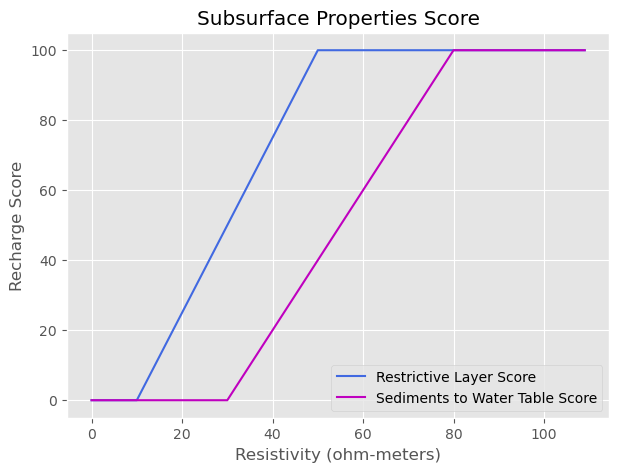

In [36]:
plt.figure(figsize=(7, 5))
plt.title("Subsurface Properties Score")
plt.plot(np.arange(110), get_score(10, 50, np.arange(110)), color = 'royalblue', label = "Restrictive Layer Score")
plt.xlabel("Resistivity (ohm-meters)")
plt.ylabel("Recharge Score")
plt.plot(np.arange(110), get_score(30, 80, np.arange(110)), color = 'm', label = "Sediments to Water Table Score")
plt.xlabel("Resistivity (ohm-meters)")
plt.ylabel("Recharge Score")
plt.legend()